<font color = 'Orange' size = 6> Satellite Dataset-RSI-CB256 trained with ENET_b0 Architecture - With Transfer Learning</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
helper_methods_folder = '/content/drive/MyDrive/AI Project/Model Training/helper_methods'

sys.path.append(os.path.abspath(helper_methods_folder))

**Importing helper methods for preprocessing, training and plotting**

In [3]:
from preprocessing import load_data
from plots import plot_data_loader, show_examples
from plots import plot_accuracy, plot_loss,plot_training_batch_loss, plot_confusion_matrix
from training import train_model, compute_accuracy_and_loss
from early_stopping import EarlyStopping
from metrics import compute_classification_report, compute_confusion_matrix
from unnormalize_images import UnNormalize
from predictions import predict_image_class

**Importing Libraries**

In [4]:
from torchvision import models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt


In [5]:
root_dir = r'/content/drive/MyDrive/AI Project/Datasets/Satellite Dataset-RSI-CB256/data'
path_to_save_model=r"/content/drive/MyDrive/AI Project/Model Training/Satellite_datatset_weights/"
file_name = "satellite_dataset_ENET_Transfer_learning"

**Load the datasets into train_loader, validation loader and test loader**

In [6]:
train_loader, test_loader, valid_loader, data = load_data(root_dir, test_split=0.2, val_split=0.1, batch_size=32, input_size=[64,64])

In [ ]:
# checking the train loader dataset information
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([3, 3, 0, 0, 0, 3, 2, 3, 3, 2])


**Encodings for the classes**

In [7]:
label_encoding = data.class_to_idx  
print("label mapping is ", label_encoding)   # save these mapping for predicition  

label mapping is  {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


**Plot the data loader**

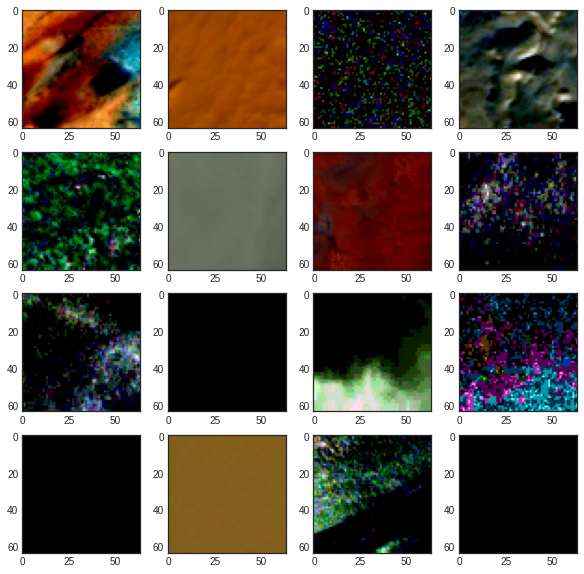

In [ ]:
plot_data_loader(train_loader, (4,4))

**Load ENET_b0 Model with pretrained Weights** 

In [8]:
model = models.efficientnet_b0(pretrained=True) 

# freeze pre-trained layers
for param in model.parameters(): 
  param.requires_grad = False

# re-define the final fully-connected layer, and this one will be trained with the dataset
# num_classes = 4
model.classifier = nn.Sequential(nn.Dropout(0.2),
                         nn.Linear(1280, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 4))

print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

**Set the hyperparameters**

In [9]:
# define the loss function for multi-class classifictaion
criterion = nn.CrossEntropyLoss()


#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 3, verbose=False)

# create and early stopping object which will be used during the training
early_stopping = EarlyStopping(tolerance=3, min_delta=0.001)

num_epochs = 40

**Train the Model with train_loader and perform validation with valid_loader**

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print("Device: {}".format(device))

model.to(device)

minibatch_loss_list, train_acc_list, valid_acc_list, train_loss_list, valid_loss_list = train_model(
    model=model,
    num_epochs=num_epochs,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion = criterion,
    optimizer=optimizer,
    device=device,
    early_stopping=early_stopping,
    file_name = file_name,
    path_to_save_model=path_to_save_model,
    scheduler=scheduler)

Device: cuda:0
Epoch: 001/040 | Batch 0000/0124 | Loss: 1.4084
Epoch: 001/040 | Batch 0100/0124 | Loss: 0.8244
Epoch: 001/040 | Train ACC: 56.25% | Validation ACC: 81.53%| Train LOSS: 1.0496| Validation LOSS: 0.7930
Time elapsed: 48.38 min
Epoch: 002/040 | Batch 0000/0124 | Loss: 0.8869
Epoch: 002/040 | Batch 0100/0124 | Loss: 0.5264
Epoch: 002/040 | Train ACC: 84.38% | Validation ACC: 84.01%| Train LOSS: 0.7076| Validation LOSS: 0.6014
Time elapsed: 48.60 min
Epoch: 003/040 | Batch 0000/0124 | Loss: 0.6257
Epoch: 003/040 | Batch 0100/0124 | Loss: 0.7750
Epoch: 003/040 | Train ACC: 73.44% | Validation ACC: 84.19%| Train LOSS: 0.6286| Validation LOSS: 0.5423
Time elapsed: 48.83 min
Epoch: 004/040 | Batch 0000/0124 | Loss: 0.6280
Epoch: 004/040 | Batch 0100/0124 | Loss: 0.6911
Epoch: 004/040 | Train ACC: 76.56% | Validation ACC: 83.66%| Train LOSS: 0.5878| Validation LOSS: 0.5838
Time elapsed: 49.05 min
Epoch: 005/040 | Batch 0000/0124 | Loss: 0.4760
Epoch: 005/040 | Batch 0100/0124 | Lo

**Test Accuracy and test loss**

In [11]:
test_acc, test_loss= compute_accuracy_and_loss(model, test_loader,criterion, device=device)
print(f'Test Accuracy {test_acc :.2f}%')
print(f'Test Loss {test_loss :.4f}')

Test Accuracy 85.17%
Test Loss 0.3964


**Plot the Training Mini_Batch_loss**

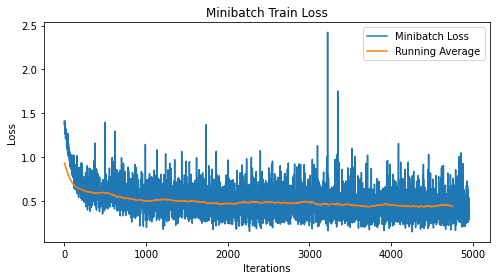

In [12]:
plot_training_batch_loss(minibatch_loss_list, num_epochs, len(train_loader))
plt.show()

**Plot train vs Validation Accuracy**

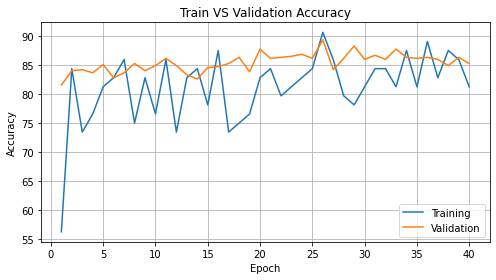

In [13]:
plot_accuracy(train_acc_list, valid_acc_list)
plt.show()

**Plot train vs Validation Loss**

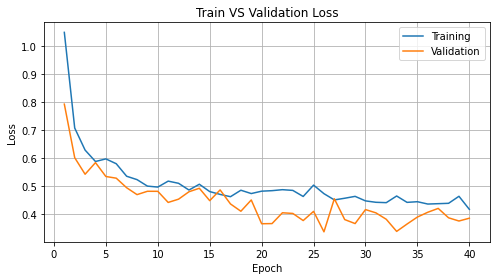

In [14]:
plot_loss(train_loss_list, valid_loss_list)
plt.show()

**Confusion Matrix**

In [15]:
label_encoding = data.class_to_idx

class_dict = {v: k for k, v in label_encoding.items()} #reverse the mapping

print(label_encoding)

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


In [ ]:
# label_encoding = {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}  # assign to a variable as it will be needed while prediciting

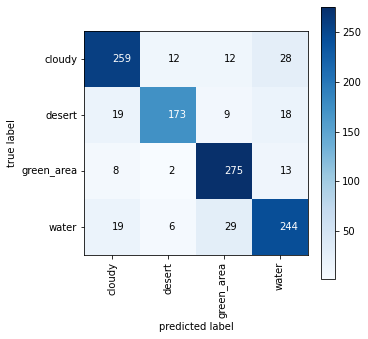

In [16]:
confusion_matrix = compute_confusion_matrix(model = model, data_loader = test_loader, device=device)
plot_confusion_matrix(confusion_matrix, class_names = class_dict.values())
plt.show()

**F1 Score, Precision and Recall**

In [17]:
print(compute_classification_report(test_loader, model, device=device ))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       317
           1       0.79      0.91      0.84       191
           2       0.91      0.88      0.89       308
           3       0.85      0.82      0.84       310

    accuracy                           0.86      1126
   macro avg       0.85      0.86      0.86      1126
weighted avg       0.86      0.86      0.86      1126



**Predicted labels Visualization**

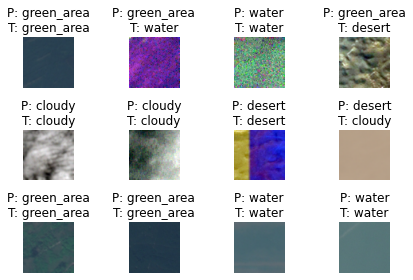

In [18]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

**Load the saved model to make predictions**

In [19]:
model  = torch.load(path_to_save_model + file_name+'_FINAL_MODEL_WEIGHTS.pth', map_location=torch.device('cpu'))

In [20]:
# test image path 
img_path = '/content/drive/MyDrive/AI Project/Model Training/test_images/water_body_103.jpg'

In [21]:
classes = ['cloudy','desert','green_area','water']
print("The predicted class is " , predict_image_class(model, img_path, classes))

The predicted class is  water
